In [1]:
from utils import *
import array 

from pydub import AudioSegment
from multiprocessing import Pool
import joblib 

%matplotlib inline

In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

In [3]:
def load_data(data_dir):
    np.random.seed = 1
    
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
#     pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    pattern  =  re.compile("(.+[\/\\\\])?(\w+)[\/\\\\]([^-]+)-.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
#     print validation_files
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry.replace("_","-"))
        if r:
            valset.add(r.group(3))
    
    possible = set(POSSIBLE_LABELS)
    
    train, val, silent, unknown = [], [],[],[]
    
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            
            if label == '_background_noise_': #we've already split up noise files into 1 seg chunks under 'silence' folder
                continue
                
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]
            sample = (label, label_id, uid, entry)
            
            if uid in valset:    
                val.append(sample)
            elif label == "silence":
                silent.append(sample)
            elif label == "unknown":
                unknown.append(sample)                

            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    
    columns_list = ['label', 'label_id', 'user_id', 'wav_file']
    

    train_df = pd.DataFrame(train, columns = columns_list)
    valid_df = pd.DataFrame(val, columns = columns_list)
    silent_df = pd.DataFrame(silent, columns = columns_list)
    unknown_df = pd.DataFrame(unknown, columns = columns_list)
    
    return train_df, valid_df, unknown_df, silent_df

In [4]:
train_df, valid_df, unknown_df, silent_df = load_data('./data/')

There are 21105 train and 6798 val samples


In [5]:
train_df.head(1)

,label,label_id,user_id,wav_file
0,left,4,b2e2773a,./data/train/audio/left/b2e2773a-nohash-1.wav


#### create validation dataframe

In [6]:
#augment validation set with silence and unknown files, made with step=250 when generating silence files
extra_data_size = int(valid_df[valid_df.label!='unknown'].shape[0]*0.1)

# unknown_val = unknown_df.sample(extra_data_size,random_state=1)
# unknown_df = unknown_df[~unknown_df.index.isin(unknown_val.index.values)]

silent_val = silent_df.sample(extra_data_size,random_state=1)
silent_df = silent_df[~silent_df.index.isin(silent_val.index.values)]


valid_df = pd.concat([valid_df,silent_val],axis=0) #,unknown_val 

In [7]:
# silence_files = train_df[train_df.label == 'silence']
# train_df      = train_df[train_df.label != 'silence']

In [8]:
%%time
# silent_df = pickle.load(open("cache/silent_df_256.pik","rb"))

silence_files_AS = [AudioSegment.from_wav(x) for x in silent_df.wav_file.values]

filler = AudioSegment.silent(duration=1000, frame_rate = 16000)


CPU times: user 468 ms, sys: 276 ms, total: 744 ms
Wall time: 3.52 s


In [9]:
train_df.label.value_counts()

stop     2134
yes      2116
up       2115
go       2112
right    2111
on       2110
left     2106
no       2105
off      2101
down     2095
Name: label, dtype: int64

In [10]:
valid_df.label.value_counts()

unknown    4221
no          270
down        264
yes         261
up          260
go          260
silence     257
on          257
right       256
off         256
left        247
stop        246
Name: label, dtype: int64

### Feature extraction, augmentation, caching

In [43]:


def augment_wav(wav,pval=0.5):
    sample_rate = 16000
    L = 1000 #16000  # 1 sec
    
#     adjust speed, with 50% chance
#     wav = speed_change(wav,1.+ random.choice([.08,-0.08])) #random.uniform(-1, 1)*0.05) if np.random.random() < pval else wav
    
    
    #adjust volume
#     db_adjustment = random.uniform(-1, 1)*10
    wav = wav + random.choice([-8,-3,7,11]) #randodb_adjustment if np.random.random() < pval else wav
     
        
    #fill to 1 second
    wav = fill_to_1sec(wav)        
        
    #shift the audio by 10 ms
    shift_length = 120
    if np.random.random() < 0.5: #shift to left
        wav = wav[:L-shift_length]+ AudioSegment.silent(shift_length,frame_rate=sample_rate)
    else: #shift to right
        wav = AudioSegment.silent(shift_length,frame_rate=sample_rate) + wav[shift_length:]
        
        
        
    #blend original file with background noise     
#     if np.random.random() < pval:
    noise = random.choice(silence_files_AS)
    db_delta = (wav.dBFS - noise.dBFS) - random.choice([8,9,10])

    if db_delta< 0: #reduce intensity of loud background; if it's too silent, leave it be
        noise = noise  + db_delta
    wav = wav.overlay(noise)
 
    return wav

def log_mel(samples,sample_rate=16000,reshape=False,n_mels=256):

		S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=n_mels,hop_length=252)

		# Convert to log scale (dB). We'll use the peak power (max) as reference.
		log_S = librosa.power_to_db(S, ref=np.max)
		log_S = log_S.reshape(log_S.shape[0],-1,1) if reshape else log_S

		return 	log_S
    
def process_wav_file(record, reshape=False, augment=False,pval=0.5 ,output_format='logmel',n_mels=128 ):
    
    if type(record) == str: # test files
        fname = record
        label = "test"
    else:    
        fname  = record.wav_file
        label = record.label

        
        
        
        
    if "raw_AS_wav" in record: 
        wav = record.raw_AS_wav
    else:
        fname = fname.replace("\\","/")
        wav = AudioSegment.from_wav(fname.replace("_","-"))
        
        
    
    if (not label in ["silence"]) and augment: #no augmentation for sample files 
        wav = augment_wav(wav,pval)

    else: #make sure segment is 1 second
        wav = fill_to_1sec(wav)

        
    samples = AS_to_raw(wav)
    
    
    
    if output_format == "logmel":
        output = log_mel(samples,reshape=reshape,n_mels=n_mels)
        
    elif output_format == "mfcc":
        log_S = log_mel(samples,reshape=False,n_mels=n_mels)
        mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=40) #hirese mfcc
        delta1 = librosa.feature.delta(mfcc, order=1)#hirese mfcc
        delta2 = librosa.feature.delta(mfcc, order=2)

        output = np.stack([mfcc,delta1,delta2])
        
    elif  output_format == "cqt":   
        samples = samples/samples
        output = librosa.cqt(samples, sr=16000 , fmin=librosa.note_to_hz('C2'),n_bins=60 * 2, bins_per_octave=12 * 2)
    else:
        output = samples
    
    
    return output


In [31]:
wav = AudioSegment.from_wav("data/train/audio/down/00176480-nohash-0.wav")

In [41]:
augment_wav(wav)

In [14]:
process_wav_file(valid_df.iloc[0],n_mels='128').shape

(128, 64)

In [15]:
AudioSegment.from_wav(valid_df.wav_file.iloc[20])

/home/ubuntu/anaconda2/lib/python2.7/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


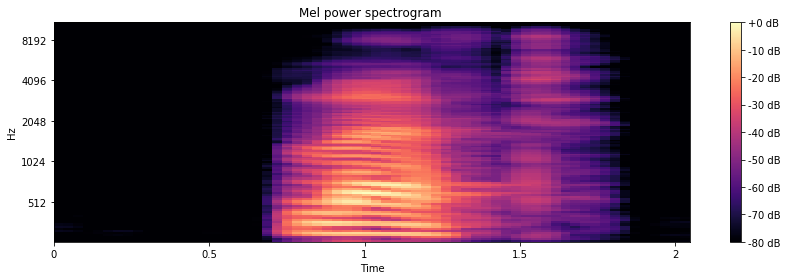

In [16]:
plot_mel(process_wav_file(valid_df.iloc[20],n_mels='128'))

In [ ]:
## plot_mel(process_wav_file(valid_df.iloc[0],n_mels='128'))

#### load existing datasets

In [5]:
%%time 

train_df = pickle.load( open("cache/train_df_waug.pik","rb"))
valid_df = pickle.load( open("cache/valid_df.pik","rb"))
silent_df = pickle.load(open("cache/silent_df.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_waug.pik","rb"))
# test_df =  pickle.load(open("cache/test_df.pik","rb"))

CPU times: user 512 ms, sys: 276 ms, total: 788 ms
Wall time: 2.39 s


In [4]:
#ignore augmentations 
train_df = train_df.iloc[:train_df.shape[0]/5]
unknown_df = unknown_df.iloc[:unknown_df.shape[0]/5]

In [6]:
def drop_mfcc_features(df):
    df.drop(['mfcc','delta1','delta2'],axis=1,inplace=True)

In [12]:
train_df.head(2)

,label,label_id,user_id,wav_file,raw,raw_AS_wav
0,left,4,cb8f8307,./data/train/audio/left/cb8f8307_nohash_1.wav,"[[-80.0, -80.0, -53.5190041125, -45.8180520192...",(((<pydub.audio_segment.AudioSegment object at...
1,left,4,b7a0754f,./data/train/audio/left/b7a0754f_nohash_2.wav,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",(((<pydub.audio_segment.AudioSegment object at...


### extract and cache mfcc-feautres
didn't help improve resuls so ignoring it 

In [53]:
%%time 
valid_df["mfcc"] = valid_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128,output_format='mfcc'))
valid_df["delta1"] = valid_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128,output_format='delta1'))
valid_df["delta2"] = valid_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128,output_format='delta2'))

CPU times: user 1min 51s, sys: 2.38 s, total: 1min 53s
Wall time: 56.8 s


In [58]:
valid_df.columns

Index([u'index', u'label', u'label_id', u'user_id', u'wav_file', u'raw',
       u'raw_AS_wav', u'mfcc', u'delta1', u'delta2'],
      dtype='object')

In [60]:
def get_mfcc_features(df):20min
    t = df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128,output_format='mfcc'))
#     df["delta1"] = df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128,output_format='delta1'))
#     df["delta2"] = df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128,output_format='delta2'))
    
    
    df["mfcc"] = t[:,:,:,0]
    df["delta1"] = t[:,:,:,1]
    df["delta2"] = t[:,:,:,2]

    return df

In [61]:
%time train_df = get_mfcc_features(train_df)

CPU times: user 19min 37s, sys: 28.3 s, total: 20min 5s
Wall time: 10min 17s


In [62]:
%time unknown_df = get_mfcc_features(unknown_df)

CPU times: user 32min 49s, sys: 45.1 s, total: 33min 34s
Wall time: 17min 13s


In [63]:
%time silent_df = get_mfcc_features(silent_df)

CPU times: user 2min 28s, sys: 3.05 s, total: 2min 31s
Wall time: 1min 15s


In [66]:
pickle.dump( train_df,open("cache/train_df.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(valid_df, open("cache/valid_df.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(silent_df, open("cache/silent_df.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(unknown_df, open("cache/unknown_df.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

### extract logmel 

In [43]:

valid_df = pickle.load( open("cache/valid_df.pik","rb"))
silent_df = pickle.load(open("cache/silent_df.pik","rb"))
# test_df =  pickle.load(open("cache/test_df.pik","rb"))

In [34]:
%time silent_df["raw"]  = silent_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128))
%time valid_df["raw"]  = valid_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128))


pickle.dump(valid_df, open("cache/valid_df_64x128.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(silent_df, open("cache/silent_df_64x128.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)



CPU times: user 5min 26s, sys: 16.2 s, total: 5min 42s
Wall time: 19.1 s
CPU times: user 18min 54s, sys: 55.5 s, total: 19min 50s
Wall time: 1min 6s


In [7]:
%time test_df["raw"]  = test_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=256))


CPU times: user 51min 19s, sys: 1min 5s, total: 52min 25s
Wall time: 28min 31s


In [8]:
pickle.dump( test_df,open("cache/test_df_256.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)


### highres logmel (64x256)

In [31]:
%time silent_df["raw"]  = silent_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128))
%time valid_df["raw"]  = valid_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128))


CPU times: user 11min 39s, sys: 42 s, total: 12min 21s
Wall time: 23.2 s
CPU times: user 40min 4s, sys: 2min 31s, total: 42min 36s
Wall time: 1min 20s


In [32]:
pickle.dump(valid_df, open("cache/valid_df_64x128.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(silent_df, open("cache/silent_df_64x128.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
%time train_df["raw"]  = train_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128))
%time unknown_df["raw"]  = unknown_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=128))


CPU times: user 1h 36min 46s, sys: 5min 37s, total: 1h 42min 23s
Wall time: 3min 12s
CPU times: user 2h 52min 1s, sys: 9min 57s, total: 3h 1min 58s
Wall time: 5min 42s


In [20]:
pickle.dump( train_df,open("cache/train_df_198.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(unknown_df, open("cache/unknown_df_198.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# test_df =  pickle.load(open("cache/test_df.pik","rb"))
# %time test_df["raw"]  = test_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,n_mels=256))
# pickle.dump(test_df, open("cache/test_df_64_256.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
train_df.shape, test_df.shape, unknown_df.shape, silent_df.shape, valid_df.shape

((21105, 5), (158538, 5), (36818, 5), (2899, 5), (7055, 5))

#### precompute augmentations 


In [17]:


def parallelize_dataframe(df, func):

    df_split = np.array_split(df, 16)
    pool = Pool(16)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df



def create_augs(df_aug):
    df_aug['raw'] = df_aug.wav_file.apply(lambda x :  process_wav_file(x,augment=True,n_mels=256))



# def multiply_columns(data):
#     data['length_of_word'] = data['species'].apply(lambda x: len(x))
#     return data
    
# iris = parallelize_dataframe(iris, multiply_columns)



In [18]:
#precomputing augs for faster neural net training

def precompute_augmentations(df,num_repeats=4,n_mels=128):
    

        
    df_aug= pd.concat([df]*num_repeats)        
#     df_aug = parallelize_dataframe(df_aug, create_augs)    #never FUCKING works .. fucking python 
    
    df_aug['raw'] = df_aug.wav_file.apply(lambda x :  process_wav_file(x,augment=True,n_mels=n_mels))
    
    df = pd.concat([df, df_aug])
    
    return df 



In [5]:
# %time train_df["raw"]  = train_df.wav_file.apply(lambda x : process_wav_file(x,n_mels=256,augment=False))
# %time unknown_df["raw"]  = unknown_df.wav_file.apply(lambda x : process_wav_file(x,n_mels=256,augment=False))
# unknown_df = pickle.load(open("cache/unknown_df_256.pik","rb"))
# train_df = pickle.load( open("cache/train_df_256.pik","rb"))

In [40]:
# %time train_df = precompute_augmentations(train_df)


# train_df.drop([u'raw_AS_wav'], axis=1,inplace=True)

# pickle.dump( train_df,open("cache/train_df_256_aug.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)


CPU times: user 1h 28min 41s, sys: 3min 35s, total: 1h 32min 16s
Wall time: 11min 33s


In [8]:
valid_df = pickle.load(open("cache/valid_df_256.pik","rb"))


In [19]:
train_df = pickle.load(open("cache/train_df_64x128_aug.pik","rb"))

In [20]:
unknown_df = pickle.load(open("cache/unknown_df_64x128_aug.pik","rb"))

In [23]:
train_df.iloc[:train_df.shape[0]/5].shape

(21105, 5)

In [42]:
train_df = train_df.iloc[:train_df.shape[0]/5]
unknown_df = unknown_df.iloc[:unknown_df.shape[0]/5]

In [44]:
%time train_df = precompute_augmentations(train_df,4,128)

KeyboardInterrupt: 

In [38]:
pickle.dump(train_df, open("cache/train_df_64x128_aug_nospeed.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
%time unknown_df = precompute_augmentations(unknown_df,4,128)

In [40]:
pickle.dump(unknown_df, open("cache/unknown_df_64x128_aug_nospeed.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

### CQT

In [10]:
y, sr = librosa.load(librosa.util.example_audio_file())

TypeError: cannot infer type for global value %r

In [9]:
temp  = AudioSegment.from_wav("data/train/audio/cat/004ae714_nohash_0.wav")

temp = np.array(temp.get_array_of_samples().tolist())

In [25]:
C = librosa.cqt(temp/np.max(temp), sr=16000, fmin=librosa.note_to_hz('C2'),n_bins=60 * 2, bins_per_octave=12 * 2)

TypeError: cannot infer type for global value %r

In [15]:
valid_df.head()

,label,label_id,user_id,wav_file
0,left,4,471a0925,./data/train/audio/left/471a0925_nohash_4.wav
1,left,4,d107dc42,./data/train/audio/left/d107dc42_nohash_0.wav
2,left,4,ec74a8a5,./data/train/audio/left/ec74a8a5_nohash_1.wav
3,left,4,50f55535,./data/train/audio/left/50f55535_nohash_0.wav
4,left,4,591d32f3,./data/train/audio/left/591d32f3_nohash_0.wav


In [14]:
valid_df["cqt"] = valid_df.wav_file.apply(lambda x : process_wav_file(x,augment=False,output_format='cqt'))

TypeError: cannot infer type for global value %r

In [4]:
C = librosa.cqt(temp, sr=16000)

TypeError: ufunc 'divide' output (typecode 'd') could not be coerced to provided output parameter (typecode 'l') according to the casting rule ''same_kind''